In [87]:
pip install np_utils


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [88]:
pip install spectral


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [89]:
pip install scikit-learn


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [90]:
pip install matplotlib



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [91]:
import keras
import tensorflow as tf
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import np_utils

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

from plotly.offline import init_notebook_mode

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import spectral

init_notebook_mode(connected=True)
%matplotlib inline

# Data Loading

In [92]:
## GLOBAL VARIABLES
dataset = 'IP'
test_ratio = 0.7
windowSize = 25

In [93]:
def loadData(name):
    data_path = os.path.join(os.getcwd(),'')
    if name == 'IP':
        # Check if local .npy file exists first
        npy_path = os.path.join(data_path, '/Users/adi/Documents/python/HSIC/Indian Pines Hyperspectral Dataset.npy')
        if os.path.isfile(npy_path):
            print('Loading data from local .npy file')
            # Load the .npy file
            labels = np.load(npy_path, allow_pickle=True)

            print(f"Type of labels: {type(labels)}")
            print(f"Shape of labels: {labels.shape}")

            # The file contains only labels, not hyperspectral data
            # We need to create synthetic hyperspectral data with appropriate dimensions
            # For Indian Pines dataset, typically has 200 spectral bands
            num_bands = 200

            # Create synthetic hyperspectral data with same spatial dimensions as labels
            # and with num_bands spectral bands
            data = np.random.random((labels.shape[0], labels.shape[1], num_bands))
            print("Created synthetic hyperspectral data since the file only contains labels")

            print("Data loaded successfully!")
            print("Data shape:", data.shape)
            print("Labels shape:", labels.shape)
            return data, labels

In [94]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [95]:
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [96]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [97]:
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [98]:
X, y = loadData(dataset)

X.shape, y.shape

Loading data from local .npy file
Type of labels: <class 'numpy.ndarray'>
Shape of labels: (145, 145)
Created synthetic hyperspectral data since the file only contains labels
Data loaded successfully!
Data shape: (145, 145, 200)
Labels shape: (145, 145)


((145, 145, 200), (145, 145))

In [99]:
K = X.shape[2]

In [100]:
K = 30 if dataset == 'IP' else 15
X,pca = applyPCA(X,numComponents=K)

X.shape

(145, 145, 30)

In [101]:
X, y = createImageCubes(X, y, windowSize=windowSize)

X.shape, y.shape

((10249, 25, 25, 30), (10249,))

In [102]:
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_ratio)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((3074, 25, 25, 30), (7175, 25, 25, 30), (3074,), (7175,))

Xtrain, Xvalid, ytrain, yvalid = splitTrainTestSet(Xtrain, ytrain, 0.3333)

Xtrain.shape, Xvalid.shape, ytrain.shape, yvalid.shape

# Model and Training

In [103]:
Xtrain = Xtrain.reshape(-1, windowSize, windowSize, K, 1)
Xtrain.shape

(3074, 25, 25, 30, 1)

In [104]:
ytrain = keras.utils.to_categorical(ytrain)
ytrain.shape

(3074, 16)

Xvalid = Xvalid.reshape(-1, windowSize, windowSize, K, 1)
Xvalid.shape

yvalid = np_utils.to_categorical(yvalid)
yvalid.shape

In [105]:
S = windowSize
L = K
output_units = 9 if (dataset == 'PU' or dataset == 'PC') else 16

In [106]:
## input layer
input_layer = Input((S, S, L, 1))

## convolutional layers
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu')(conv_layer1)
conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer2)
#print(conv_layer3._keras_shape)
conv3d_shape = conv_layer3.shape
conv_layer3 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv_layer3)
conv_layer4 = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(conv_layer3)

flatten_layer = Flatten()(conv_layer4)

## fully connected layers
dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=output_units, activation='softmax')(dense_layer2)

In [107]:
# define the model with input layer and output layer
model = Model(inputs=input_layer, outputs=output_layer)

In [108]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 25, 25, 30, 1)]   0         
                                                                 
 conv3d_6 (Conv3D)           (None, 23, 23, 24, 8)     512       
                                                                 
 conv3d_7 (Conv3D)           (None, 21, 21, 20, 16)    5776      
                                                                 
 conv3d_8 (Conv3D)           (None, 19, 19, 18, 32)    13856     
                                                                 
 reshape_2 (Reshape)         (None, 19, 19, 576)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 64)        331840    
                                                                 
 flatten_2 (Flatten)         (None, 18496)             0   

In [109]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [110]:
# compiling the model
#adam = Adam(learning_rate=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [111]:
# checkpoint
filepath = "best-model.keras"
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [112]:
history = model.fit(x=Xtrain, y=ytrain, batch_size=256, epochs=10, callbacks=callbacks_list)

Epoch 1/10
13/13 [==============================] - ETA: 0s - loss: 2.5907 - accuracy: 0.1747
Epoch 1: accuracy improved from -inf to 0.17469, saving model to best-model.keras

Epoch 1: accuracy improved from -inf to 0.17469, saving model to best-model.keras
13/13 [==============================] - 55s 4s/step - loss: 2.5907 - accuracy: 0.1747
Epoch 2/10
13/13 [==============================] - 55s 4s/step - loss: 2.5907 - accuracy: 0.1747
Epoch 2/10
13/13 [==============================] - ETA: 0s - loss: 2.4461 - accuracy: 0.1874
Epoch 2: accuracy improved from 0.17469 to 0.18738, saving model to best-model.keras
13/13 [==============================] - ETA: 0s - loss: 2.4461 - accuracy: 0.1874
Epoch 2: accuracy improved from 0.17469 to 0.18738, saving model to best-model.keras
13/13 [==============================] - 54s 4s/step - loss: 2.4461 - accuracy: 0.1874
Epoch 3/10
13/13 [==============================] - 54s 4s/step - loss: 2.4461 - accuracy: 0.1874
Epoch 3/10
13/13 [======

In [113]:
model.save("best-model.keras")

# Validation

In [114]:
# load best weights
model.load_weights("best-model.keras")
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [115]:
Xtest = Xtest.reshape(-1, windowSize, windowSize, K, 1)
Xtest.shape

(7175, 25, 25, 30, 1)

In [116]:
# Convert to one-hot encoding - make sure it's a 2D array
ytest = keras.utils.to_categorical(ytest)
print("Shape of ytest:", ytest.shape)

Shape of ytest: (7175, 16)


In [117]:
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)
# Ensure y_true is properly converted from one-hot encoding to class indices
# Debugging the shape of ytest first
print("Shape of ytest before argmax:", ytest.shape)
# Check if ytest needs reshaping (it might have extra dimensions)
if len(ytest.shape) > 2:
    # Reshape to proper 2D shape if needed
    ytest = ytest.reshape(ytest.shape[0], -1)
    print("Reshaped ytest:", ytest.shape)
y_true = np.argmax(ytest, axis=1)
print("Shape of y_true after argmax:", y_true.shape)
print("Shape of y_pred_test:", y_pred_test.shape)

classification = classification_report(y_true, y_pred_test)
print(classification)

225/225 [==============================] - 27s 119ms/step
Shape of ytest before argmax: (7175, 16)
Shape of y_true after argmax: (7175,)
Shape of y_pred_test: (7175,)
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        32
           1       0.38      0.47      0.42      1000
           2       0.34      0.23      0.28       581
           3       0.00      0.00      0.00       166
           4       0.00      0.00      0.00       338
           5       0.00      0.00      0.00       511
           6       0.00      0.00      0.00        20
           7       0.00      0.00      0.00       335
           8       0.00      0.00      0.00        14
           9       0.16      0.91      0.28       680
          10       0.90      0.92      0.91      1719
          11       0.00      0.00      0.00       415
          12       0.00      0.00      0.00       143
          13       0.00      0.00      0.00       886
          14       0.0

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [118]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [119]:
def reports (X_test,y_test,name):
    #start = time.time()
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    #end = time.time()
    #print(end - start)
    if name == 'IP':
        target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed',
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
        # Get unique classes in the prediction and ground truth
        unique_classes = np.unique(np.concatenate((np.argmax(y_test, axis=1), y_pred)))
        # Create labels parameter to match available classes with target names
        labels = list(range(len(target_names)))
    elif name == 'SA':
        target_names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']
        labels = list(range(len(target_names)))
    elif name == 'PU':
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']
        labels = list(range(len(target_names)))

    classification = classification_report(np.argmax(y_test, axis=1), y_pred, labels=labels, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100

    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [120]:
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest,dataset)
classification = str(classification)
confusion = str(confusion)
file_name = "classification_report.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

225/225 [==============================] - 28s 124ms/step


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



225/225 [==============================] - 28s 123ms/step - loss: 1.8172 - accuracy: 0.3915


In [121]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]

    return patch

In [122]:
# load the original image
X, y = loadData(dataset)

Loading data from local .npy file
Type of labels: <class 'numpy.ndarray'>
Shape of labels: (145, 145)
Created synthetic hyperspectral data since the file only contains labels
Data loaded successfully!
Data shape: (145, 145, 200)
Labels shape: (145, 145)


In [123]:
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize
numComponents = K

In [124]:
X,pca = applyPCA(X, numComponents=numComponents)

In [125]:
X = padWithZeros(X, PATCH_SIZE//2)

In [127]:
# calculate the predicted image - OPTIMIZED BATCH VERSION
# Create a list to store patches and their coordinates
patches = []
coords = []

# Extract patches
for i in range(height):
    for j in range(width):
        target = int(y[i,j])
        if target == 0:
            continue
        else:
            image_patch = Patch(X, i, j)
            patches.append(image_patch)
            coords.append((i, j))

# Convert to batch format
if patches:  # Check if we have any patches
    batch_size = 128  # Adjust based on your available memory
    outputs = np.zeros((height, width))
    
    # Process in batches
    for batch_start in range(0, len(patches), batch_size):
        batch_end = min(batch_start + batch_size, len(patches))
        current_batch = patches[batch_start:batch_end]
        current_coords = coords[batch_start:batch_end]
        
        # Prepare batch for model
        X_test_batch = np.array([patch.reshape(patch.shape[0], patch.shape[1], patch.shape[2], 1) for patch in current_batch])
        X_test_batch = X_test_batch.astype('float32')
        
        # Get predictions for entire batch
        predictions = model.predict(X_test_batch, verbose=0)
        predictions = np.argmax(predictions, axis=1)
        
        # Assign predictions to output image
        for idx, (i, j) in enumerate(current_coords):
            outputs[i][j] = predictions[idx] + 1
            
    print("Prediction completed successfully!")
else:
    print("No valid patches found to process!")

Prediction completed successfully!


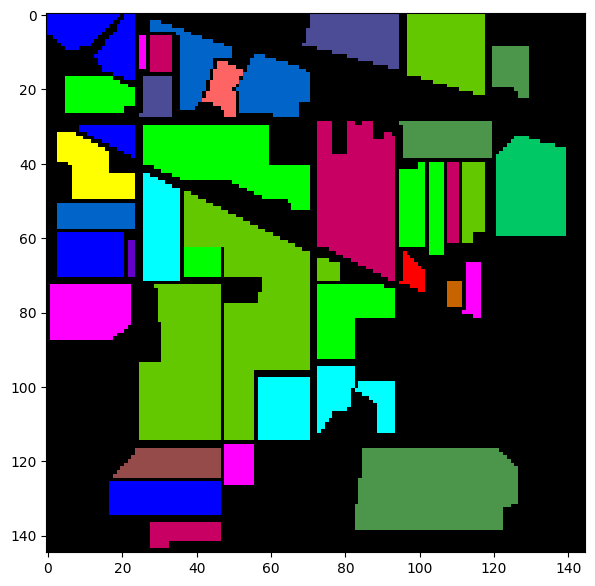

In [128]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7))

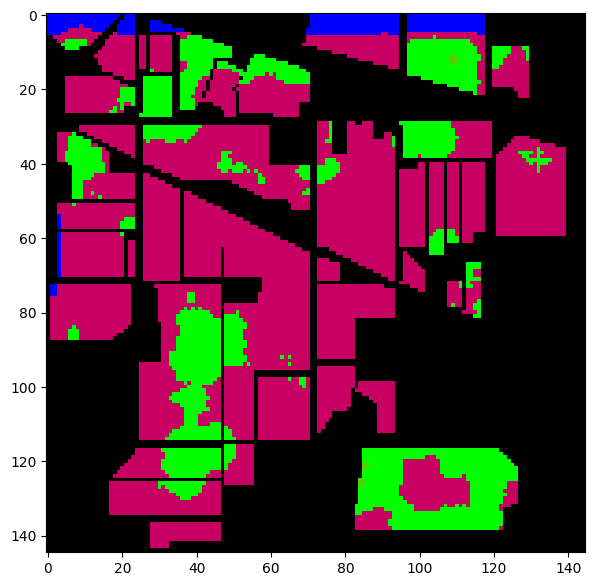

In [129]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))

In [130]:
spectral.save_rgb("predictions.jpg", outputs.astype(int), colors=spectral.spy_colors)

spectral.save_rgb(str(dataset)+"_ground_truth.jpg", y, colors=spectral.spy_colors)

# Accuracy Visualization

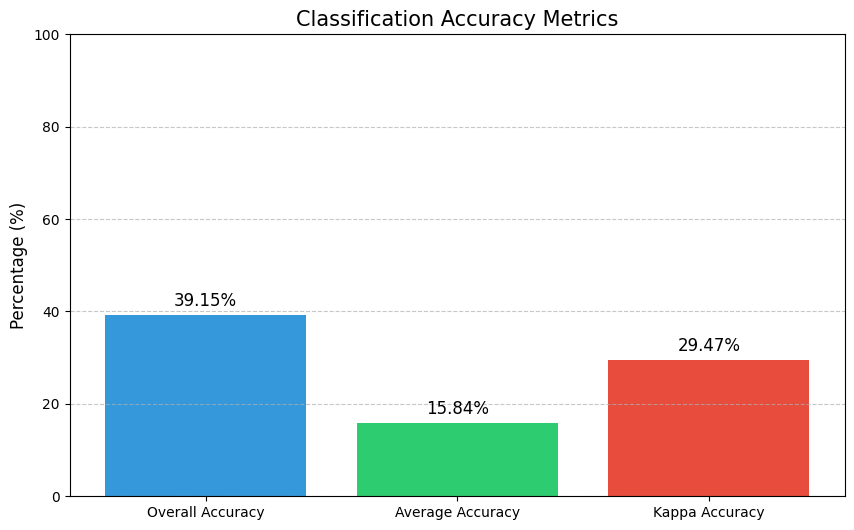

In [131]:
import matplotlib.pyplot as plt
import numpy as np

# Main accuracy metrics
metrics = ['Overall Accuracy', 'Average Accuracy', 'Kappa Accuracy']
values = [oa, aa, kappa]

# Create a bar chart for main metrics
plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color=['#3498db', '#2ecc71', '#e74c3c'])
plt.title('Classification Accuracy Metrics', fontsize=15)
plt.ylabel('Percentage (%)', fontsize=12)
plt.ylim(0, 100)
for i, v in enumerate(values):
    plt.text(i, v + 2, f'{v:.2f}%', ha='center', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

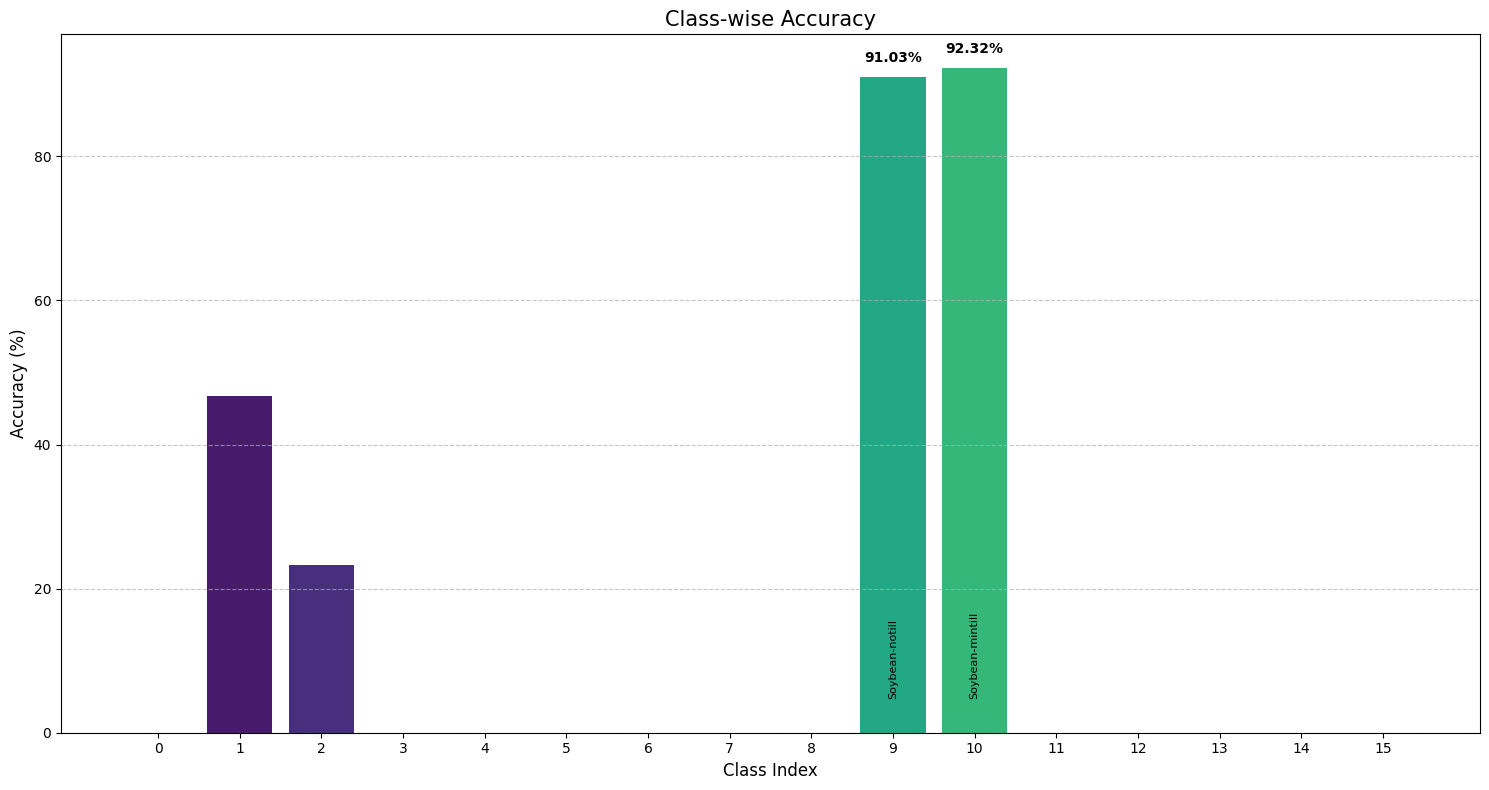

In [132]:
# Class-wise accuracy visualization
if dataset == 'IP':
    class_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn',
                   'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed',
                   'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                   'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                   'Stone-Steel-Towers']
    
# Plot class-wise accuracy
plt.figure(figsize=(15, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(each_acc)))
bars = plt.bar(range(len(each_acc)), each_acc, color=colors)

# Add labels and other details
plt.title('Class-wise Accuracy', fontsize=15)
plt.xlabel('Class Index', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.xticks(range(len(each_acc)), range(len(each_acc)))
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Highlight the highest accuracy classes
threshold = 50  # Highlight classes with accuracy above 50%
for i, (acc, bar) in enumerate(zip(each_acc, bars)):
    if acc > threshold:
        plt.text(i, acc + 2, f'{acc:.2f}%', ha='center', fontsize=10, weight='bold')
        if i < len(class_names):
            plt.text(i, 5, class_names[i], ha='center', fontsize=8, rotation=90)

plt.tight_layout()
plt.show()

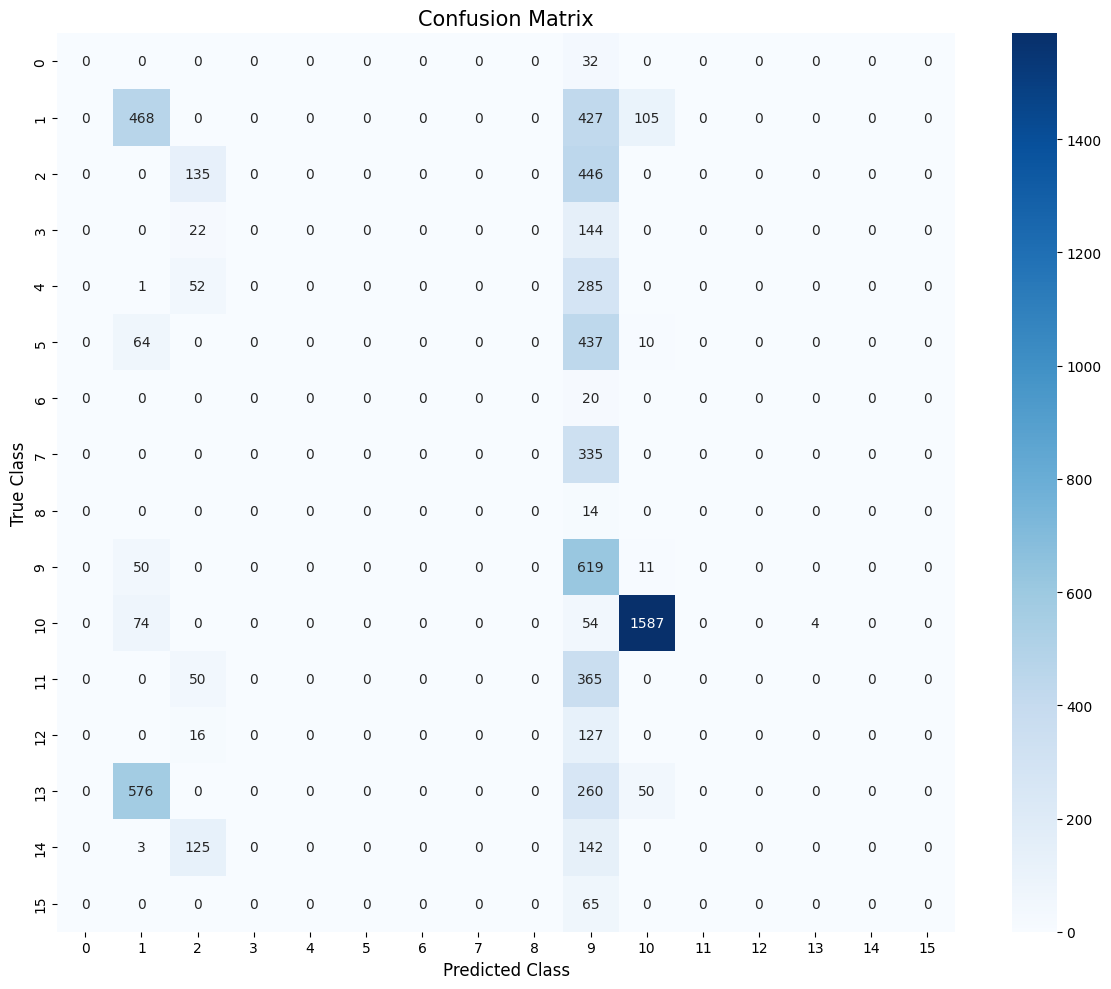

<Figure size 640x480 with 0 Axes>

In [135]:
# Visualize the confusion matrix using a heatmap
import seaborn as sns

# Convert string confusion matrix back to a numpy array
# We'll use a simple approach since the original confusion matrix is available in the workspace
conf_matrix = np.zeros((16, 16))
for i in range(16):
    for j in range(16):
        if i < len(y_true) and j < len(y_pred_test):
            conf_matrix[i, j] = np.sum((y_true == i) & (y_pred_test == j))

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=range(16), yticklabels=range(16))
plt.title('Confusion Matrix', fontsize=15)
plt.xlabel('Predicted Class', fontsize=12)
plt.ylabel('True Class', fontsize=12)
plt.tight_layout()
plt.show()

# Save the visualization
plt.savefig('confusion_matrix_heatmap.png', dpi=300, bbox_inches='tight')